# CSC2611 Lab: Word embedding and semantic change

Katie Warburton

### Imports

In [1]:
import numpy as np
import pickle
from scipy import stats
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt

## 1. Synchronic word embedding

### Load models

In [2]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
# Construct a Gnsim KeyedVectors model from word vectors
def load_LSA_model(file):
    with open(file, 'rb') as f:
        M1_300, M1_idx = pickle.load(f)
    vocab = [key for key in M1_idx.keys()]
    model = KeyedVectors(300)
    model.add_vectors(vocab, M1_300)
    return model, vocab
M1_300, vocab = load_LSA_model('m1_300.pkl')

### Compare similarity

#### Load pairs from Table 1 

In [4]:
# Read in pair data from table 1 of RG65
def load_table(file):
    word_pairs = []
    sim = []
    with open(file, 'r') as f:
        for line in f:
            data = line.split()
            word_pairs.append(tuple(data[:2]))
            sim.append(float(data[2]))
    return word_pairs, sim

P, S = load_table('table1.txt')

In [5]:
# Parse word pairs and remove ones not in a models vocabulary
def get_valid_pairs(pairs, sims, vocab):
    new_pairs, new_sims = [], []
    for i in range(len(pairs)):
        if pairs[i][0] in vocab and pairs[i][1] in vocab:
            new_pairs.append(pairs[i])
            new_sims.append(sims[i])
    return new_pairs, new_sims

P, S = get_valid_pairs(P, S, vocab)

#### Calculate pair similarity

In [6]:
# Extract a word's vector
def extract_embeddings(pairs, model):
    vec_pairs = []
    for w1, w2 in pairs:
        vec_pairs.append((model[w1], model[w2]))
    return vec_pairs

In [7]:
# Compute cosine similarity
def cosine_sim(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [8]:
# Calculate cosine similarity between word pairs
def calc_pair_sims(pairs):
    sims = []
    for v1, v2 in pairs:
        sim = cosine_sim(v1, v2)
        sims.append(sim)
    return sims

In [9]:
# Compute pearson correlation between computed and target similarities 
def compare_sims(model, pairs, similarities):
    vec_pairs = extract_embeddings(pairs, model)
    sim_calc = calc_pair_sims(vec_pairs)
    r, _ = stats.pearsonr(similarities, sim_calc)
    return r

r = compare_sims(word2vec, P, S)

#### Word2vec vs. human similarity judgement

In [10]:
print(f'Pearson correlation: {round(r, 4)}')

Pearson correlation: 0.7601


### Analogy Task

#### Load analogy data

In [11]:
# Load data for analogy task
def load_analogies(file):
    analogies = []
    with open(file, 'r') as f:
        for line in f:
            analogies.append(line.split())
    return analogies

data = load_analogies('word-test.txt')

In [12]:
# Sort analogy tests and remove tests for words not in a vocabulary
def get_tests(analogies, vocab):
    tests = {}
    for line in analogies[1:]:
        if line[0] == ':':
            key = line[1]
            tests[key] = []
        else:
            # ensure all test words are in the vocabulary 
            if all(w.lower() in vocab for w in line):
                tests[key].append(line)
    # remove any test sets with no valid analogies
    tests = {key: value for key, value in tests.items() if len(value)>0}
    return tests

tasks = get_tests(data, vocab)

#### Perform analogy test

In [13]:
# Predict the missing words in a set of analogies
# Return list of 1s and 0s corresponding to correct and incorrect predictions
# respectively
def predict(analogies, model):
    predictions = []
    for w1, w2, w3, w4 in analogies:
        blank = model.most_similar(positive=[w2, w3], negative=[w1], topn=1)[0][0]
        if blank == w4:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [14]:
# Perform the analogy test using word2vec
def analogy_task_wv(tasks, model):
    accuracies = {}
    for name in tasks.keys():
        analogies = tasks[name]
        # 1 = correct prediction, 0 = incorrect
        predictions = predict(analogies, model)
        acc = sum(predictions)
        accuracies[name] = [(acc/len(predictions)), len(predictions)]
    return accuracies 
accuracies_wv = analogy_task_wv(tasks, word2vec)

In [15]:
# Perform the analogy test using LSA model
def analogy_task_lsa(tasks, model):
    accuracies = {}
    for name in tasks.keys():
        # model only contains lowercased words
        analogies = [[w.lower() for w in analogy] for analogy in tasks[name]]
        predictions = predict(analogies, model)
        acc = sum(predictions)
        accuracies[name] = [(acc/len(predictions)), len(predictions)]
    return accuracies 
accuracies_lsa = analogy_task_lsa(tasks, M1_300)

In [16]:
# Calculate and display the performance of a model on the analogy task
def get_accuracy(accuracies):
    sem_acc, sem_count = 0, 0
    syn_acc, syn_count = 0, 0
    for key, value in accuracies.items():
        # all syntactic tasks contain the word 'gram'
        if 'gram' in key:
            # weight each subtasks accuracy by number of analogies
            syn_acc += value[0]*value[1]
            syn_count += value[1]
        else:
            sem_acc += value[0]*value[1]
            sem_count += value[1]
    sem_acc = round((sem_acc / sem_count)*100, 2)
    syn_acc = round((syn_acc / syn_count)*100, 2)
    print(f'Syntactic accuracy: {syn_acc}%\nSemantic accuracy: {sem_acc}%')

In [17]:
print("Word2vec analogy task accuracy")
get_accuracy(accuracies_wv)
print("\nLSA model analogy task accuracy")
get_accuracy(accuracies_lsa)

Word2vec analogy task accuracy
Syntactic accuracy: 68.78%
Semantic accuracy: 87.65%

LSA model analogy task accuracy
Syntactic accuracy: 6.54%
Semantic accuracy: 20.99%


## Diachronic word embedding

### Prepare diachronic word embeddings

Load and format the diachronic word embeddings for analysis. 

*Note*: There is a small selection of words with zero vectors from 1900 - 1940. For ease of comparison I will remove these vectors as I assume the zero vector means that there was no data for that word in that decade. I ended up with 1994 words for evaluation

In [18]:
# Load diachronis word embeddings 
def load_diachronic(file):
    with open(file, 'rb') as f:
        time_data = pickle.load(f)
    w = time_data['w']
    d = time_data['d']
    E = time_data['E']
    return w, d, E

w, d, E,  = load_diachronic('data.pkl')

In [19]:
# Remove words from the dataset that do not occur in every decade
# ASSUMPTIN: zero vector means word was not found in a decade's data
def clean_data(words, vectors):
    words_v2 = []
    vectors_v2 = []
    for i in range(len(vectors)):
        flag = False
        for vec in vectors[i]:
            # if there is a zero vector. 
            if not np.any(vec):
                flag = True
        if not flag:
            words_v2.append(words[i])
            vectors_v2.append(vectors[i])
    return words_v2, vectors_v2

w, E = clean_data(w, E)

In [20]:
# Create matrices of vector embedding spaces for each decade
def get_vector_space(E, d):
    E_by_date = [np.array([E[i][j] for i in range(len(E))]) 
                 for j in range(len(d))]
    return [np.array(vec_list) for vec_list in E_by_date]

vec_spaces = get_vector_space(E, d)

### Method 1: Nearest neighbours

Measuring degree of semantic change by comparing how many nearest neighbours a word has in common with its nearest neighbours from 1900 andn 1990

In [21]:
# Return the K nearest neighbours of a word in a vector space
def get_nearest_neighbours(word, vector_space, k):
    numer = np.dot(vector_space, word)
    denom = np.linalg.norm(vector_space, axis=1) * np.linalg.norm(word)
    out = np.divide(numer, denom)
    # sorted - closest will always be word of interest
    idx = set(out.argsort()[-(k+1):-1])
    return idx

In [22]:
# Return the size of the set intersection between 2 nearest neighbour sets
def compare_nn(word_idx, vec_spaces_t1, vec_spaces_t2, k):
    word_t1 = vec_spaces_t1[word_idx]
    word_t2 = vec_spaces_t2[word_idx]
    # each word_idx is unique so don't have to convert back to compare 
    idx_t1 = get_nearest_neighbours(word_t1, vec_spaces_t1, k)
    idx_t2 =  get_nearest_neighbours(word_t2, vec_spaces_t2, k)
    overlap = len(idx_t1.intersection(idx_t2))/k
    return overlap 

In [23]:
# Compute degree of semantic change according to method 1
def semantic_change_1(words, vec_spaces, t1, t2):
    overlaps = np.zeros(len(words))
    for i in range(len(words)):
        overlap = compare_nn(i, vec_spaces[t1], vec_spaces[t2], 50)
        overlaps[i] = overlap
    return overlaps

degree_of_change_1 = semantic_change_1(w, vec_spaces, 0, -1)

In [24]:
# Display n most and least changing words
def print_n(array, words, n):
    sort_arr = list(np.argsort(array)[::-1])
    n_max = sort_arr[-n:]
    n_min = sort_arr[:n]
    max_out = 'Top 20 most changing words'
    min_out = 'Top 20 least changing words'
    for i in range(n):
        max_out += f'\n{words[n_max[n-i-1]]}'
        min_out += f'\n{words[n_min[i]]}'
    print(max_out + "\n\n" + min_out)
    

In [25]:
print_n(degree_of_change_1, w, 20)

Top 20 most changing words
sector
approach
assessment
radio
objectives
impact
signal
focus
perspective
shift
patterns
programs
models
media
goals
agency
post
film
model
gap

Top 20 least changing words
months
day
sand
alexander
autumn
uncle
officer
afternoon
weeks
george
week
john
river
thomas
mathematics
wheat
centuries
fuel
mother
knees


### Method 2: Matrix Alignment
Align matrix from time t1 with matrix from time t2 so the cosine similarity between a word's embeddings in two different time periods can be directly compared. 

Alignment method based on the webpage "[FINDING OPTIMAL ROTATION AND TRANSLATION BETWEEN CORRESPONDING 3D POINTS](http://nghiaho.com/?page_id=671)"

In [26]:
# Determine the optimal rotation and translation between 2 matrices
# Apply the transformation to matrix 1 and return the result
def align_matrices(mat1, mat2):
    centroid1 = np.mean(mat1, axis=0)
    centroid2 = np.mean(mat2, axis=0)
    H = np.matmul((mat1-centroid1).T, (mat2-centroid2))
    U, _, V = np.linalg.svd(H)
    R = np.matmul(U, V)
    t = centroid2 - np.dot(R, centroid1)
    mat1_trans = np.matmul(mat1, R) + t
    return mat1_trans

In [27]:
# Compute degree of semantic change according to method 2
def semantic_change_2(words, vec_spaces, t1, t2):
    sims = np.zeros(len(words))
    vec_space_t2 = vec_spaces[t2]
    vec_space_t1_align = align_matrices(vec_spaces[t1], vec_space_t2)
    for i in range(len(words)):
        v1, v2 = vec_space_t1_align[i], vec_space_t2[i] 
        # higher sim = more changed
        sim = cosine_sim(v1, v2)
        sims[i] = sim
    return sims

degree_of_change_2 = semantic_change_2(w, vec_spaces, 0, -1)

In [28]:
print_n(degree_of_change_2, w, 20)

Top 20 most changing words
objectives
programs
radio
patterns
assessment
film
approach
sector
perspective
media
impact
goals
framework
signal
challenge
berkeley
economy
trend
jobs
wilson

Top 20 least changing words
april
november
february
september
legislature
miles
majority
duties
evening
christ
church
june
morning
december
officers
father
officer
afternoon
january
son


### Method 3: Similarity to nearest neighbours

Calculate the cosine similarity between a word and its nearest neighbout at time t1 and again (with the same nearest neighbout) at time t2. Subtract the similarity at t2 from t1 and take the absolute value of the difference. 

In [29]:
# Compute degree of semantic change according to method 2
def semantic_change_3(words, vec_spaces, t1, t2):
    sim_changes = np.zeros(len(words))
    vec_space_t1 = vec_spaces[t1]
    vec_space_t2 = vec_spaces[t2]
    for i in range(len(words)):
        v1, v2 = vec_space_t1[i], vec_space_t2[i]
        # get nearest neighbour
        nn_idx = list(get_nearest_neighbours(v1, vec_space_t1, 1))[0]
        nn1, nn2 = vec_space_t1[nn_idx], vec_space_t2[nn_idx]
        # compute change in cosine similarity 
        change = abs(cosine_sim(v1, nn1) - cosine_sim(v2, nn2))
        sim_changes[i] = 1 - change
    return sim_changes

degree_of_change_3 = semantic_change_3(w, vec_spaces, 0, -1)

In [30]:
print_n(degree_of_change_3, w, 20)

Top 20 most changing words
impact
film
radio
protein
assessment
alcohol
signal
acid
phases
state
illustrations
shadow
screen
affairs
approach
goal
basis
pattern
disposition
mixture

Top 20 least changing words
academy
duty
duties
year
appeal
appeals
volumes
volume
pace
temperature
temperatures
extension
projects
project
darkness
grass
anxiety
step
professor
song


### Method intercorrelations

In [31]:
# Measure the intercorrelation among methods
def get_pairwise_corr(methods):
    n = len(methods)
    out = "\t\tMethod 1\tMethod 2\tMethod 3"
    for i in range(n):
        out += f"\nMethod {i+1}\t"
        for j in range(n):
            r, _ = stats.pearsonr(methods[i], methods[j])
            out += f"{r:.4f}\t\t"
    print(out)
    
get_pairwise_corr([degree_of_change_1, degree_of_change_2, degree_of_change_3])

		Method 1	Method 2	Method 3
Method 1	1.0000		0.6087		0.3037		
Method 2	0.6087		1.0000		0.3668		
Method 3	0.3037		0.3668		1.0000		


### Evaluate Methods

In [32]:
# Load semantic_change scores
def load_change_scores(file, words):
    n = len(words)
    scores = np.zeros(n)
    j = 0
    with open(file, 'rb') as f:
        dat = pickle.load(f, encoding='latin1')
    for i in range(n):
        if words[i] in dat.keys():
            # semantic change between 1900 and 1990
            scores[i] = dat[words[i]][1900]
        else:
            j += 1
    return scores

change_scores = load_change_scores('disps.pkl', w)

In [33]:
# Determine which words have attested scores
def get_non_zero(scores):
    idx = np.nonzero(scores)
    return idx[0]

In [34]:
# Compare methods of measuring semantic change to values from
# an attested model
def compare_methods(scores, methods):
    idx = get_non_zero(scores)
    scores = scores[idx]
    out = "Method\tPearson correlation\tP-value"
    for i in range(len(methods)):
        method_scores = methods[i][idx]
        r, p = stats.pearsonr(scores, method_scores)
        out += f"\n{i+1}\t{round(r, 4)}\t\t\t"
        if p < 0.0001:
            out += "<0.0001"
        else:
            out += f"{round(p, 4)}"
    print(out)

In [35]:
compare_methods(change_scores, [degree_of_change_1, degree_of_change_2, degree_of_change_3])

Method	Pearson correlation	P-value
1	0.6951			<0.0001
2	0.7262			<0.0001
3	0.3614			<0.0001


### Detecting point(s) of semantic change

Detecting the point(s) of semantic change for the top 3 changing words according to method 2. 

In [36]:
# Find and return the top n most changing words and their indices
def max_n(array, words, n):
    sort_arr = list(np.argsort(array)[::-1])
    n_max = sort_arr[-n:]
    n_max.reverse()
    top_words = [words[i] for i in n_max]
    return top_words, n_max

top_3, w_idx = max_n(degree_of_change_2, w, 3)
print(f"The top 3 most changing words are " + ", ".join(top_3))

The top 3 most changing words are objectives, programs, radio


In [37]:
# Detect the point(s) of semantic change
def detect_semantic_change(w_idx, vec_spaces):
    changes = []
    change_points = []
    for i in range(len(vec_spaces)-1):
        vec_space_t2 = vec_spaces[-1]
        vec_space_t1_align = align_matrices(vec_spaces[i], vec_space_t2)
        v1, v2 = vec_space_t1_align[w_idx], vec_space_t2[w_idx] 
        sim = cosine_sim(v1, v2)
        changes.append(sim)
    # pairwise rate of change between semantic change scores
    pw_rate_of_change = [abs(changes[i+1] - changes[i]) 
                         for i in range(len(changes)-1)]
    # find points where similarity changes significantly
    change_points = [i+1 for i in range(len(pw_rate_of_change)) 
                     if pw_rate_of_change[i] > 0.1]
    return changes, change_points
changes, change_points =  detect_semantic_change(w.index('objectives'), vec_spaces)

In [38]:
# Plot a word's meaning along a time series
def plot_change_point(changes, dates, word, change_points):
    n = len(changes)
    fig, ax = plt.subplots() 
    ax.scatter([i for i in range(n)], changes, color='forestgreen')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel('cosine similarity')
    plt.xlabel('decade')
    plt.title(f"Semantic change of '{word}' overtime'")
    plt.xticks([i for i in range(n)], dates[:-1])
    plt.ylim(0, 1)
    ax.vlines(x=change_points, ymin=0, ymax=1, 
              color='orange', ls=':', label='change point')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

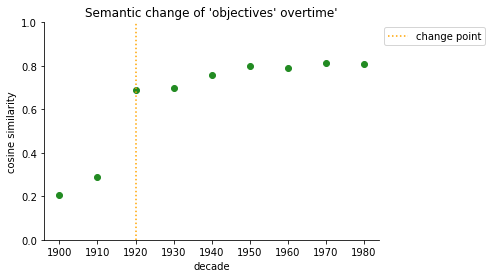

In [39]:
changes, change_points = detect_semantic_change(w_idx[0], vec_spaces)
plot_change_point(changes, d, top_3[0], change_points)

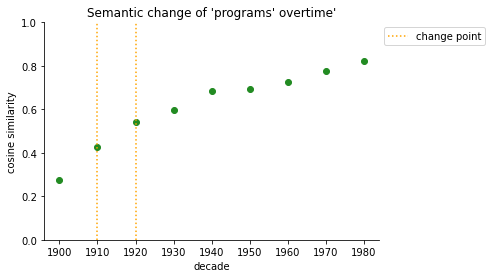

In [40]:
changes, change_points = detect_semantic_change(w_idx[1], vec_spaces)
plot_change_point(changes, d, top_3[1], change_points)

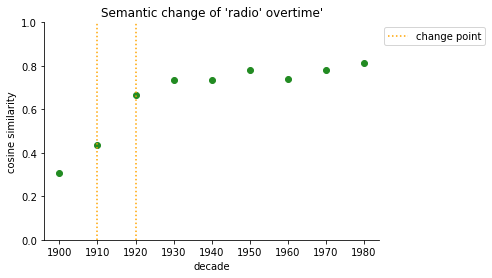

In [41]:
changes, change_points = detect_semantic_change(w_idx[2], vec_spaces)
plot_change_point(changes, d, top_3[2], change_points)